Data prepared with 4 selected features.
Selected features: ['state', 'sttl', 'ct_state_ttl', 'ct_dst_sport_ltm']

K-Means Parameters: k=8, Anomaly Threshold: 55th percentile
Anomaly Threshold Value: 0.0676831625683617

Classification Report (1=Anomaly/Attack, 0=Normal) - Optimized K-Means:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     56000
           1       0.82      0.71      0.76     56000

    accuracy                           0.78    112000
   macro avg       0.78      0.78      0.77    112000
weighted avg       0.78      0.78      0.77    112000

Accuracy: 77.55%
Mean Squared Error (MSE): 0.2245
Mean Absolute Error (MAE): 0.2245


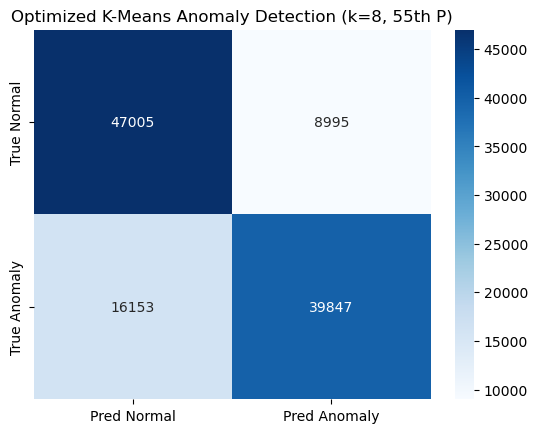


✅ Training Complete.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# 1. Load Dataset & Balance
# ========================================
data = pd.read_csv(r"E:\Mini Project\Network Behavior Analysis Mini Project\Dataset\UNSW_NB15_testing-set.csv")
normal_df = data[data["label"] == 0]
attack_df = data[data["label"] == 1]
attack_sample = attack_df.sample(len(normal_df), random_state=42)
balanced_df = pd.concat([normal_df, attack_sample], axis=0).reset_index(drop=True)

# ========================================
# 2. Preprocessing
# ========================================
X = balanced_df.drop(columns=["label", "id", "attack_cat"], errors="ignore")
y = balanced_df["label"]

for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

# ========================================
# 3. Feature Selection: Top 4 Features
# ========================================
k_features_to_select = 4
selector = SelectKBest(score_func=f_classif, k=k_features_to_select)
X_final = selector.fit_transform(X_scaled_array, y)

selected_features_mask = selector.get_support()
selected_feature_names = X.columns[selected_features_mask]

# ========================================
# 4. K-Means Clustering: k=8
# ========================================
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_final)

# ========================================
# 5. Calculate Distance & Apply Threshold
# ========================================
distances = kmeans.transform(X_final)
min_distances = np.min(distances, axis=1)

threshold_percentile = 55
anomaly_threshold = np.percentile(min_distances, threshold_percentile)

# Predict anomalies
balanced_df["pred_anomaly"] = (min_distances > anomaly_threshold).astype(int)
y_pred = balanced_df["pred_anomaly"]

# ========================================
# 6. Evaluation (Including MSE and MAE)
# ========================================
print(f"Data prepared with {X_final.shape[1]} selected features.")
print("Selected features:", list(selected_feature_names))
print(f"\nK-Means Parameters: k={optimal_k}, Anomaly Threshold: {threshold_percentile}th percentile")
print("Anomaly Threshold Value:", anomaly_threshold)

print("\nClassification Report (1=Anomaly/Attack, 0=Normal) - Optimized K-Means:")
print(classification_report(y, y_pred))

accuracy = accuracy_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Anomaly"],
            yticklabels=["True Normal", "True Anomaly"])
plt.title(f"Optimized K-Means Anomaly Detection (k={optimal_k}, {threshold_percentile}th P)")
plt.show()

# Save Model
joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(selector, 'selector.joblib')
joblib.dump(anomaly_threshold, 'training_anomaly_threshold.joblib')

print("\n✅ Training Complete.")


--- Starting Testing Phase (with Adjusted Threshold) ---

--- PREDICTION COUNTS ---
Predicted Normal (0): 58810
Predicted Anomaly (1): 116531


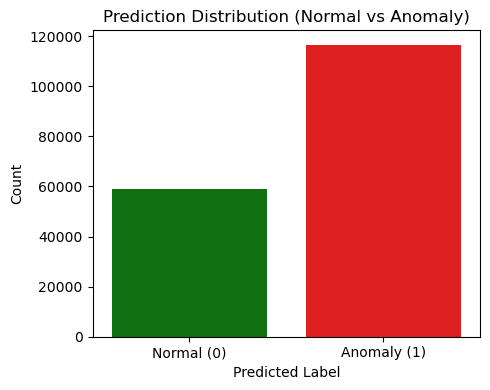

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- TESTING PARAMETERS ---
NEW_TESTING_THRESHOLD_PERCENTILE = 30
# --------------------------

def test_saved_model():
    """Loads saved artifacts and tests the model on the testing set."""
    print("\n--- Starting Testing Phase (with Adjusted Threshold) ---")

    # Load Model Artifacts
    try:
        loaded_kmeans = joblib.load("kmeans_model.joblib")
        loaded_scaler = joblib.load("scaler.joblib")
        loaded_selector = joblib.load("selector.joblib")
    except FileNotFoundError:
        print("❌ Error: Model artifacts not found. Run 'train_and_save.py' first.")
        return

    # Load the test data
    test_data = pd.read_csv(r"E:\Mini Project\Network Behavior Analysis Mini Project\Dataset\UNSW_NB15_testing-set.csv")
    X_test = test_data.drop(columns=["label", "id", "attack_cat"], errors="ignore")
    y_test = test_data["label"]

    # Preprocessing Test Data
    for col in X_test.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))

    X_scaled_array_test = loaded_scaler.transform(X_test)
    X_final_test = loaded_selector.transform(X_scaled_array_test)

    # 1. Calculate distances on the test set
    distances_test = loaded_kmeans.transform(X_final_test)
    min_distances_test = np.min(distances_test, axis=1)

    # 2. Re-calculate the threshold
    new_anomaly_threshold = np.percentile(min_distances_test, NEW_TESTING_THRESHOLD_PERCENTILE)

    # Apply the new threshold
    y_pred_test = (min_distances_test > new_anomaly_threshold).astype(int)

    # ✅ Added: Count predictions
    unique, counts = np.unique(y_pred_test, return_counts=True)
    prediction_counts = dict(zip(unique, counts))

    print("\n--- PREDICTION COUNTS ---")
    print(f"Predicted Normal (0): {prediction_counts.get(0, 0)}")
    print(f"Predicted Anomaly (1): {prediction_counts.get(1, 0)}")

    # ✅ Updated: Visualize prediction distribution without warning
    plt.figure(figsize=(5, 4))
    sns.countplot(x=y_pred_test, hue=y_pred_test, palette=["green", "red"], legend=False)
    plt.xticks([0, 1], ['Normal (0)', 'Anomaly (1)'])
    plt.title("Prediction Distribution (Normal vs Anomaly)")
    plt.xlabel("Predicted Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    test_saved_model()
